# Elasticidade de preço - Sales:

### Objetivos:
- Quantificar a elasticidade-preço por produto, região e segmento de clientes.
- Identificar produtos com elasticidade baixa e alta.
- Criar modelo preditivo que estime a demanda em função do preço.
- Avaliar impacto financeiro esperado para diferentes estratégias de precificação.
- Sugerir ações para aumentar o ticket médio e faturamento com base no modelo.

---
Para esse projeto vou utilizar a seguinte estrutura:

1. Definição do problema (Pode ser encontrada no ReadMe)
2. Coletar dados e gerar uma visão geral
3. Dividir em treinamento e teste
4. EDA - Analise exploratória de dados
5. Feature engineering, limpeza e pré processamento.
6. Treinamento de modelo e feature selection.
7. Produção final do modelo, avaliação e testes.
8. Conclusão e interpretar resultados.
9. Deploy e implementação
---
*Ao final de cada bloco vou trazer meus insights e minhas decisões*

---
### Estrutura do Dataset:
| Coluna        | Descrição                                                           |
|---------------|---------------------------------------------------------------------|
| Sales Person  | *Nome do vendedor responsável pela transação*                       |
| Country	      | *Região de vendas ou localização da loja onde a transação ocorreu*  |
| Product       | *Nome do produto de chocolate vendido*                              |
| Date          | *A data da transação da venda de chocolate*                         |
| Amount        | *Receita total gerada a partir da venda.*                           |
| Boxes Shipped | *Número de caixas de chocolate enviadas na ordem.*              |



### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from elasticidadepreco.outliers import outliersCalc
from elasticidadepreco.elasticidade import elasticidade
from sklearn.preprocessing import StandardScaler
from elasticidadepreco.graphics import categoricalDistri
from   elasticidadepreco.graphics import numericalDistri
from elasticidadepreco.graphics import bivariate_analysis
import warnings

# sns.set_palette("dark:#5A9_r")

warnings.filterwarnings('ignore')

### Entendendo os dados

link dataset:https://www.kaggle.com/datasets/atharvasoundankar/chocolate-sales?select=Chocolate+Sales.csv

In [2]:
df = pd.read_csv('../data/raw/Chocolate Sales.csv', encoding='utf-8')

In [3]:
df.head()

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,07-Jul-22,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27-Apr-22,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24-Feb-22,"$13,685",184


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sales Person   1094 non-null   object
 1   Country        1094 non-null   object
 2   Product        1094 non-null   object
 3   Date           1094 non-null   object
 4   Amount         1094 non-null   object
 5   Boxes Shipped  1094 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 51.4+ KB


In [5]:
print(f'{df.shape[0]} linhas  \n{df.shape[1]} colunas')

1094 linhas  
6 colunas


In [6]:
df.isnull().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df = df.rename(columns={
    'Sales Person': 'sales_person',
    'Country': 'country',
    'Product': 'product',
    'Date': 'date',
    'Amount': 'amount',
    'Boxes Shipped': 'boxes_shipped',
})

In [9]:
df['amount'] = df['amount'].str.replace('[\$,]', '', regex=True).str.strip().astype(int)

In [10]:
df['country'] = df['country'].astype('category')

In [11]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

Insights:
- Alterei o nome de colunas para um formato mais amigavel
- Alterei os tipos para facilitar os processos
- E limpei um pouco a variavel de amount e data, para gerar analises mais precisas

### Divisão de treinamento e testes

In [12]:
X = df.drop(columns=['boxes_shipped'])
y = df['boxes_shipped'].copy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
print(f'X_train shape: {X_train.shape}.')
print(f'x_train shape: {y_train.shape}.')
print(f'X_test shape: {X_test.shape}.')
print(f'y_test shape: {y_test.shape}.')

X_train shape: (875, 5).
x_train shape: (875,).
X_test shape: (219, 5).
y_test shape: (219,).


Insights:
- Realizei a divisão dos dados aqui, para não haver vazamento de dados e gerar um overfitting, a partir daqui as analises serão nos dados train


### Analise Exploratória de Dados - EDA

#### Univariada - Distribuições e features padrão

In [15]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

,sales_person,country,product,date,amount,boxes_shipped
6,Oby Sorrel,UK,99% Dark & Pure,2022-01-25,13685,176
789,Ches Bonnell,New Zealand,Caramel Stuffed Bars,2022-06-30,7588,42
1049,Ches Bonnell,India,99% Dark & Pure,2022-02-16,455,96
837,Kaine Padly,Australia,50% Dark Bites,2022-08-02,8995,78
661,Gunar Cockshoot,Canada,50% Dark Bites,2022-01-04,3024,23


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 875 entries, 6 to 860
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sales_person   875 non-null    object        
 1   country        875 non-null    category      
 2   product        875 non-null    object        
 3   date           875 non-null    datetime64[ns]
 4   amount         875 non-null    int32         
 5   boxes_shipped  875 non-null    int64         
dtypes: category(1), datetime64[ns](1), int32(1), int64(1), object(2)
memory usage: 38.7+ KB


In [17]:
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train.select_dtypes(exclude=[np.number, np.datetime64]).columns.tolist()

In [18]:
for col in categorical_features:
    print(f'{col} valores únicos: {train[col].nunique()}')
    print('-' *40)

sales_person valores únicos: 25
----------------------------------------
country valores únicos: 6
----------------------------------------
product valores únicos: 22
----------------------------------------


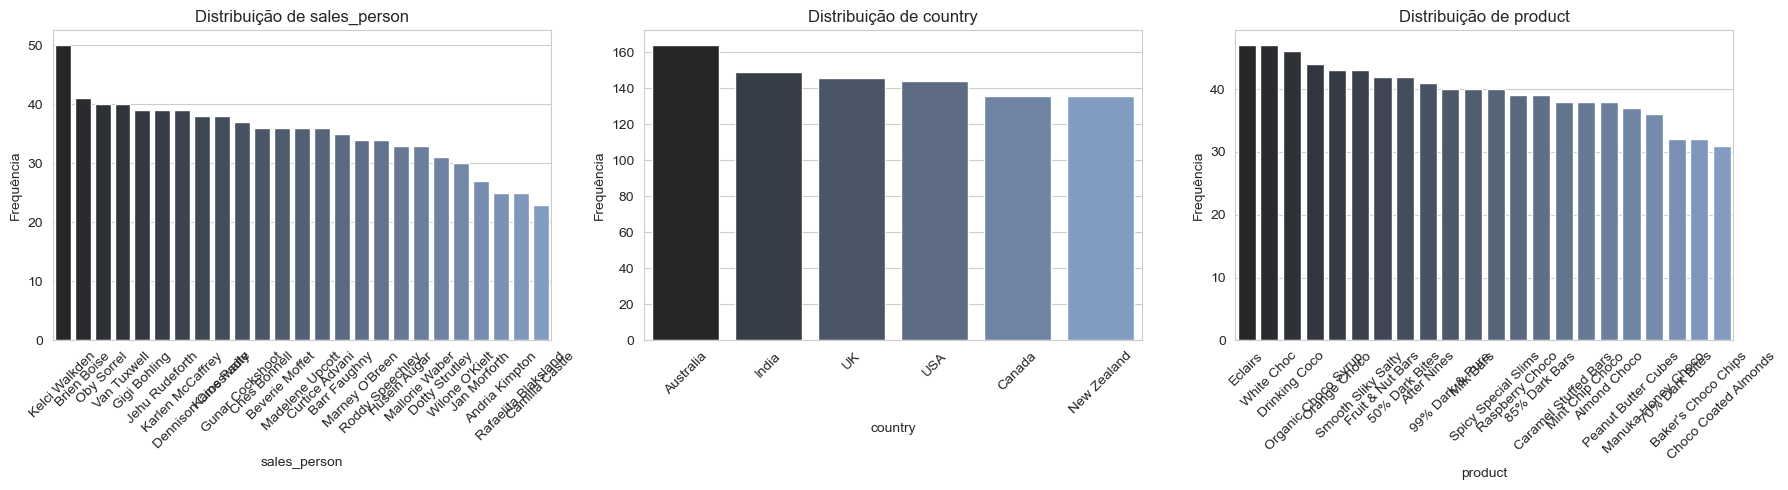

In [19]:
categoricalDistri(train,categorical_features)

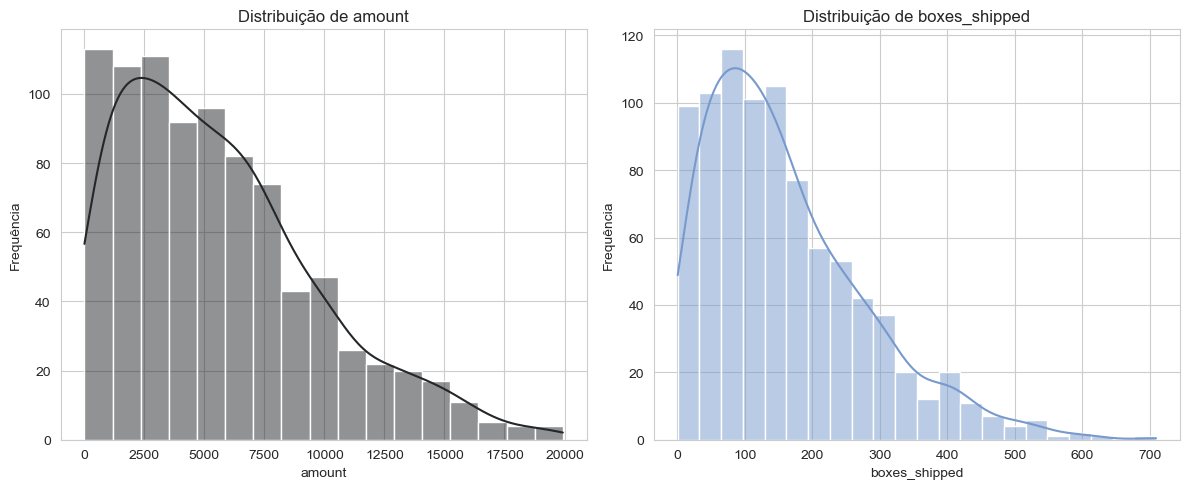

In [20]:
numericalDistri(train,numeric_features,2)

Insights:

- Muitas vendas com pouca boxes_shipped(caixas entregues) e com receita total baixa(amount), significa que a maior frequencia das transações são com baixo faturament por unidade de venda e baixo numero de caixas entregues, indicando uma provavel relação direta entre numero de boxes_shipped com amount (não acredito muito nisso, mas é bom registrar para validar)
- Existem produtos/vendas com uma elasticidade muito baixa, indicando um ou mais produtos muito inelasticos, porem aponta um extremo positivo com alta elasticidade, podendo ser um produto bem flexivel a preço/demanda, mas em geral, a maior frequencia esta indicando inelasticidade. Ou seja, temos poucos produtos que se encaixam na caracteristica de aumento de preço com baixo impacto na demanda
- Vemos uma semelhancia nas curva de amount e de boxes_shipped, indicando talvez uma possível relação entre essas features
- A medida em que o amount vai aumentando, o numero de caixas vendidas/entregues vai diminuindo também, isso reforça minha hipotese que comentei no insghts dos dados categoricos
- Atualização da tese: 'Quando menor é o preço mais caixas são vendidas'
- Talvez seja interessante criar faixas de preço(amount) ja que no grafico podemos observar algumas faixas(colunas) que possuem mínimos semelhantes e uma distancia baixa de max entre elas, uma faixa de preço ajudaria a mostrar de forma mais clara a diferença da frequencia(vendas) em relação ao preço
- Nos dados change_qtd, change_price e elasticty, tive que usar a log scale para conseguir visualizar os dados de forma mais clara p
- Podemos observar que a amplitude deles é alta, com alguns numeros negativos e outros bem mais avançados, isso pode indicar uma variação de preço do mesmo produto em diferentes relacionamento (pais,vendedor,quantidade,etc.) já que, na pratica, mostra que os preços aumentaram, depois diminuiram, tiveram uma variação, porém isso ocorreu poucas vezes, como mostram os graficos
- Vemos que a maior frequencia de elasticidade está indicando estar proximo ou menor que 1 (10^0), indicando uma tendência geral de produtos inelasticos e unitariamente elasticos, que significa que a variação de preço deles impacta a quantidade vendida (demanda), vou confirmar esse ponto analisando mais as correlações das features

Insights:

- Todos os vendedores fizeram mais que 20 vendas, todos os paises realizaram mais que 120 vendas e todos os produtos estiveram em mais que 20 ordens(transações)
- 22 vendedores atuam em 6 paises diferentes com 22 produtos cadastrados
- Em country e em sales_person , vemos que os valores com maior frequencia de vendas estão a uma grande distância do segundo colado
- Em product temos 2 chocolates com a mesma quantidade de vendas, e a distância para os outros valores não é tão significativa enquanto de country e sales_person
- Em country temos apenas 6 valores diferentes e que são não ordinais, ou seja, posso aplicar um OneHot enconding nessa feature
- Tenho uma hipotese de que em Australia e o vendedor Top 1 , estejam com a menor média de amount (preço) e com a maior média em quantidade de caixa vendidas. Levando em consideração o pensamento lógico de que a quantidade de vendas alta poderia indicar produtos com ticket baixo, fazendo-os focar em vender mais e mais de produtos "baratos". Vou amadurecer esse ideia para posteriormente validar a hipotese

#### Bivariada - Relações simples e Tratamento de Outliers

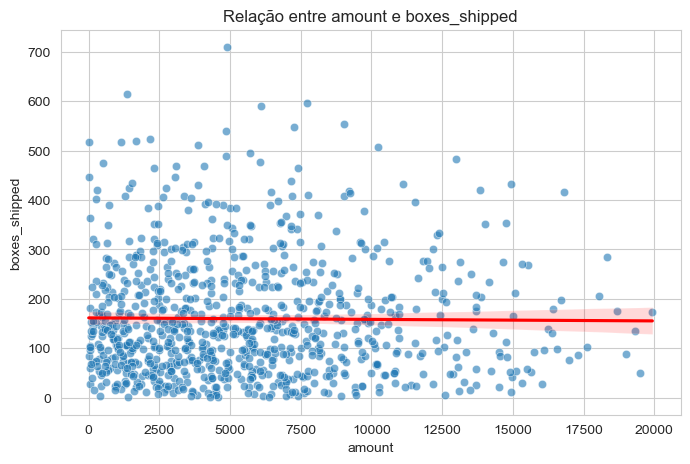

In [21]:
#NumXNum
bivariate_analysis(train,'amount','boxes_shipped')

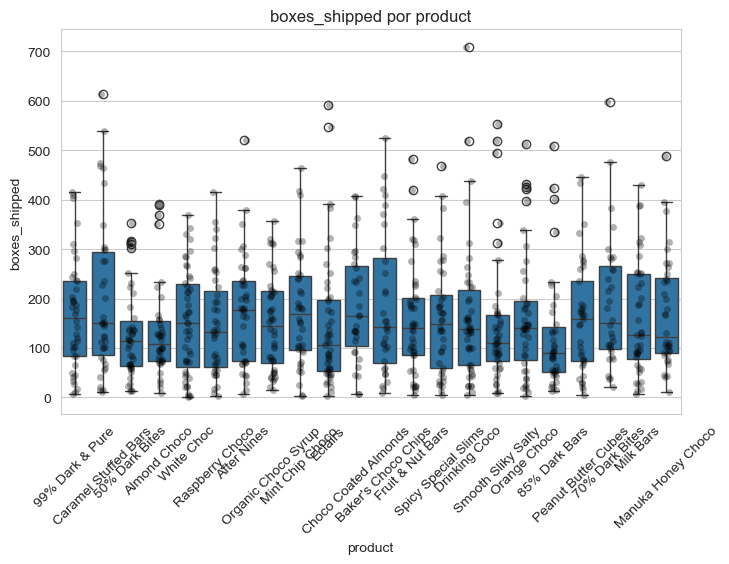

In [22]:
bivariate_analysis(train,'product','boxes_shipped')


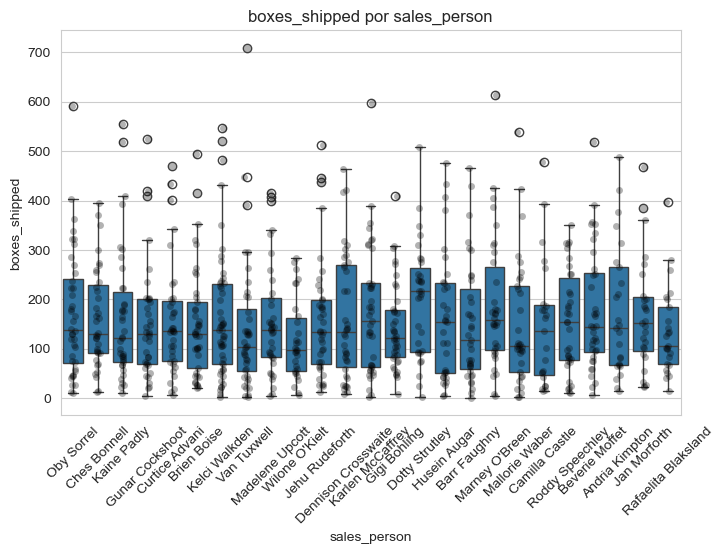

In [23]:
bivariate_analysis(train,'sales_person','boxes_shipped')


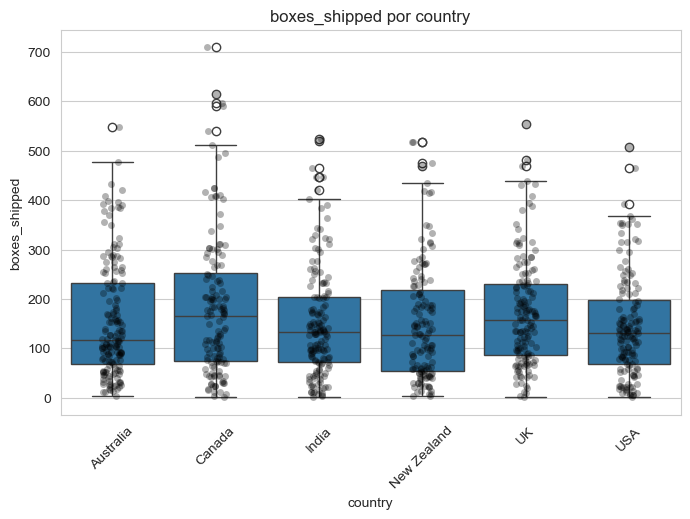

In [24]:
bivariate_analysis(train,'boxes_shipped','country')


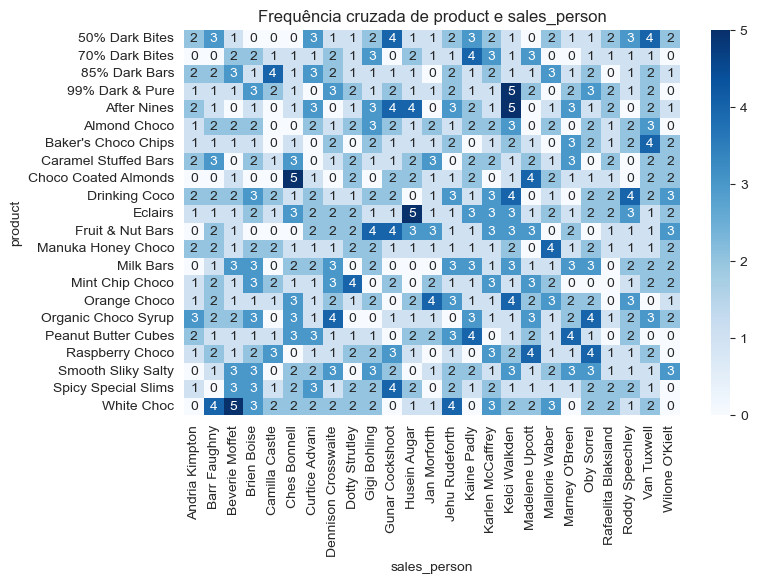

In [25]:
bivariate_analysis(train,'product','sales_person')


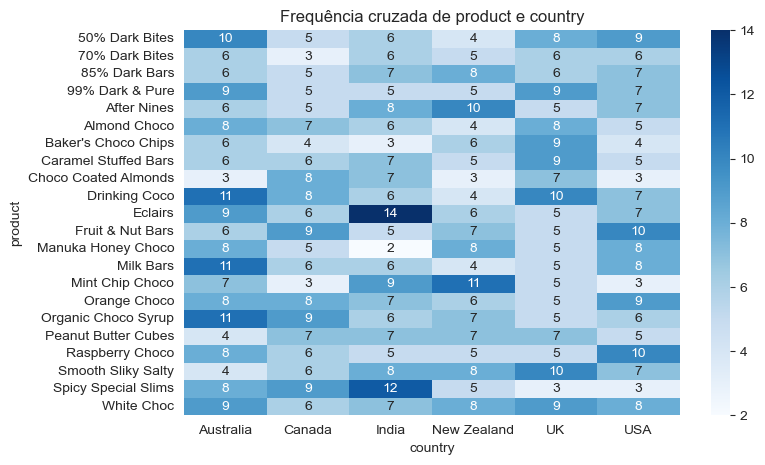

In [26]:
bivariate_analysis(train,'product','country')


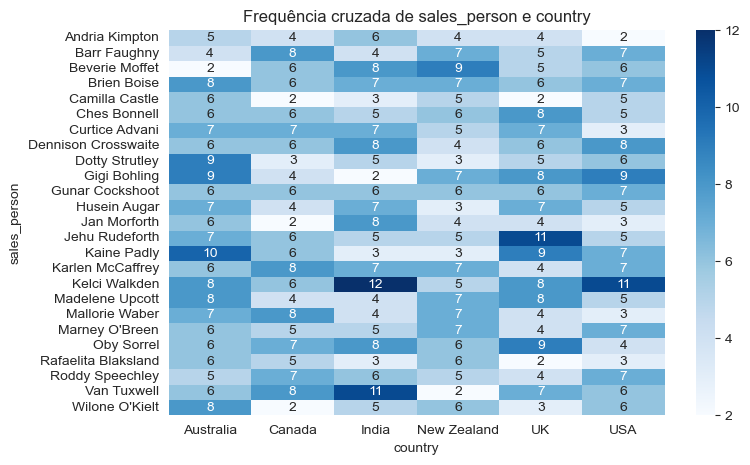

In [27]:
bivariate_analysis(train,'sales_person','country')


In [28]:
#Outliers
outliers = outliersCalc(train[numeric_features])
outliers[numeric_features].sum() / len(train[numeric_features]) * 100

amount           1.714286
boxes_shipped    2.514286
dtype: float64

Insights:

- oi
- oi

#### Multivariada - Enriquecimento de features + novos KPI´s

In [33]:
# calculado de elasticidade

In [30]:
#calculado de ticket medio

In [31]:
# segmentar vendedor

In [32]:
# Elasticidade por produto, região, segmento de vendedor

In [34]:
#produtos com elasticidade baixa e alta

In [35]:
#segmentação de produtos premium

In [36]:
#comportamento vendedores

In [37]:
#correlação

In [38]:
#Pairplot

In [39]:
#PCA

Insights:

- algo
- oi

#### Séries temporais e Sazonalidade

### Insights e hipóteses -  Respondendo perguntas

### Para Modelagem